<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/PytorchCharLvlRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [9]:
base_path = "/content/drive/MyDrive/PyTorchRNNData/"

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a **bunch of names**, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).  
We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [15]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles(base_path + 'data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(base_path + 'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/PyTorchRNNData/data/names/French.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Scottish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Korean.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Italian.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Irish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Russian.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Dutch.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Chinese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Vietnamese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Polish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Greek.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/English.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Japanese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Spanish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Czech.txt', '/content/drive/MyDrive/PyTorchRNNData/data/n

In [17]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That **extra 1 dimension** is because PyTorch assumes everything is in batches - we’re just using a **batch size of 1** here.

In [18]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size()) # No. of Chars * 1 (batch_size) * 
                                    # char_vocab_size

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Creating the Network**  
Before **autograd**, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a **LogSoftmax** layer after the output.
  
the PyTorch for Torch users tutorial
https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net

In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of **efficiency** we don’t want to be creating a new Tensor for every step, so we will use **lineToTensor** instead of letterToTensor and use slices. This could be **further optimized by pre-computing batches of Tensors**.

In [21]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9697, -2.9177, -2.8803, -2.8745, -2.8617, -2.9582, -2.8889, -2.8797,
         -2.8306, -2.9083, -2.9527, -2.9027, -2.8650, -2.7936, -2.8673, -2.8925,
         -2.9509, -2.8508]], grad_fn=<LogSoftmaxBackward0>)


Before going into training we should make a few helper functions. The first is to **interpret the output of the network**, which we know to be a likelihood of each category. We can use `Tensor.topk` to **get the index of the greatest value**:

In [22]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 13)


In [23]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Puga
category = French / line = Deniaud
category = German / line = Kaspar
category = Greek / line = Sortras
category = Vietnamese / line = Thai
category = Japanese / line = Kondo
category = Japanese / line = Shintaro
category = Czech / line = Janick
category = Greek / line = Anetakis
category = Portuguese / line = Abreu


Now all it takes to train this network is show it a bunch of examples, **have it make guesses**, and **tell it if it’s wrong**.

For the loss function **nn.NLLLoss** is appropriate, since the last layer of the RNN is **nn.LogSoftmax**.    
  
  
  
    

**What is the difference between softmax and logsoftmax in pytorch?**

In case of the Softmax Function, it is applied to an n-dim input tensor in which it will be rescaling them so that the elements of the output n-dim tensor lie in the range [0,1] and sum to 1. The function will return the similar shape and dimension as the input with the values in range[0,1]. The Softmax function is defined as:
`Softmax(xi)= exp(xi) / ∑ j exp(xj)`
In the case of Logsoftmax function which is nothing but **the log of Softmax** function. It will return the same shape and dimension as the input with the values in the range [-inf, 0]. The Logsoftmax function is defined as:
`LogSoftmax(xi) = log (exp(xi) / ∑ j exp(xj))`

**What loss function should I use?**  
https://stats.stackexchange.com/questions/436766/cross-entropy-with-log-softmax-activation
Obviously, working on the log scale, or the logit scale, requires making algebraic adjustments so that the loss is also on the appropriate scale. So if you use identity activations in the final layer, you use `CrossEntropyLoss`. If you use log_softmax in the final layer, you use `NLLLoss`.

In [25]:
criterion = nn.NLLLoss()

Each loop of training will:

*   Create input and target tensors

*   Create a zeroed initial hidden state

*   Read each letter in and

*   Keep hidden state for next letter

*   Compare final output to target

*   Back-propagate

*   Return the output and loss

In [27]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.8209 Noyes / Greek ✗ (English)
10000 10% (0m 6s) 1.1715 Duan / Chinese ✓
15000 15% (0m 10s) 2.5985 Bouchard / Japanese ✗ (French)
20000 20% (0m 13s) 3.2339 Burns / Portuguese ✗ (Scottish)
25000 25% (0m 16s) 0.9006 Truong / Vietnamese ✓
30000 30% (0m 20s) 2.6086 Gass / Greek ✗ (German)
35000 35% (0m 23s) 0.4428 Zhuchenko / Russian ✓
40000 40% (0m 26s) 0.1883 Toselli / Italian ✓
45000 45% (0m 30s) 2.4722 Philips / Greek ✗ (Dutch)
50000 50% (0m 33s) 2.0585 D'cruz / Spanish ✗ (Portuguese)
55000 55% (0m 36s) 1.6168 Gwang  / Korean ✓
60000 60% (0m 39s) 1.8240 Gutierrez / Czech ✗ (Spanish)
65000 65% (0m 43s) 2.4557 Deschamps / Italian ✗ (French)
70000 70% (0m 46s) 0.1519 Reinders / Dutch ✓
75000 75% (0m 52s) 1.3671 Gil / Chinese ✗ (Korean)
80000 80% (0m 57s) 0.9457 Mateus / Portuguese ✓
85000 85% (1m 0s) 2.1581 Maria / Spanish ✗ (Portuguese)
90000 90% (1m 4s) 0.4369 Kwang  / Korean ✓
95000 95% (1m 7s) 0.8979 Black / Scottish ✓
100000 100% (1m 10s) 0.3223 Campos / Portuguese 

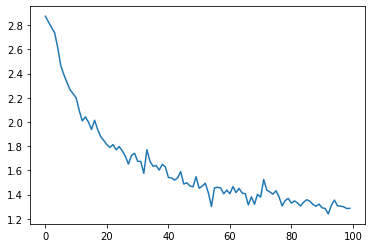

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

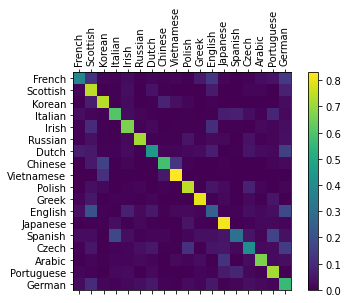

In [30]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

Running on User Input

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.77) Russian
(-0.97) Czech
(-2.64) English

> Jackson
(-0.16) Scottish
(-2.28) English
(-4.01) Czech

> Satoshi
(-1.26) Japanese
(-1.36) Italian
(-2.19) Arabic
